This script is freely inspired from [this](https://github.com/dvalenzano/uBiome_Network/blob/master/metabolite-finder.ipynb)

In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

/Users/DValenzano/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [15]:
met_all = open('/Volumes/group_dv/group/metabolome/01_2018/jupyter/serum_Nov2015.txt', 'rU').read()
keys = open('/Volumes/group_dv/group/metabolome/01_2018/jupyter/sample_key_microbiota_rnaseq_metabolomics.csv', 'rU').read()

In [16]:
kkeys = [i.split(',')[4] for i in keys.split('\n')[1:] if i.split(',')[4] != '-']
kvalues = [i.split(',')[1] for i in keys.split('\n')[1:] if i.split(',')[4] != '-']
kdict = dict(zip(kkeys, kvalues))

In [18]:
met_all.split('\n')[0].split('\t').index('A1')

32

In [19]:
met1 = [[i.split('\t')[2]]+[i.split('\t')[5]]+i.split('\t')[32:] for i in met_all.split('\n')]

In [24]:
#[met1.index(i) for i in met1  if i[1]!= '' ][:20] #This line finds the indexes where the metabolite is known

In [25]:
import scipy.stats
#scipy.stats.mstats.kruskalwallis

In [26]:
#import numpy as np
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
import warnings

In [42]:
def kw_dunn(groups, to_compare=None, alpha=0.05, method='bonf'):
    """
    Kruskal-Wallis 1-way ANOVA with Dunn's multiple comparison test
    Arguments:
    ---------------
    groups: sequence
        arrays corresponding to k mutually independent samples from
        continuous populations
    to_compare: sequence
        tuples specifying the indices of pairs of groups to compare, e.g.
        [(0, 1), (0, 2)] would compare group 0 with 1 & 2. by default, all
        possible pairwise comparisons between groups are performed.
    alpha: float
        family-wise error rate used for correcting for multiple comparisons
        (see statsmodels.stats.multitest.multipletests for details)
    method: string
        method used to adjust p-values to account for multiple corrections (see
        statsmodels.stats.multitest.multipletests for options)
    Returns:
    ---------------
    H: float
        Kruskal-Wallis H-statistic
    p_omnibus: float
        p-value corresponding to the global null hypothesis that the medians of
        the groups are all equal
    Z_pairs: float array
        Z-scores computed for the absolute difference in mean ranks for each
        pairwise comparison
    p_corrected: float array
        corrected p-values for each pairwise comparison, corresponding to the
        null hypothesis that the pair of groups has equal medians. note that
        these are only meaningful if the global null hypothesis is rejected.
    reject: bool array
        True for pairs where the null hypothesis can be rejected for the given
        alpha
    Reference:
    ---------------
    Gibbons, J. D., & Chakraborti, S. (2011). Nonparametric Statistical
    Inference (5th ed., pp. 353-357). Boca Raton, FL: Chapman & Hall.
    """

    # omnibus test (K-W ANOVA)
    # -------------------------------------------------------------------------

    groups = [np.array(gg) for gg in groups]

    k = len(groups)

    n = np.array([len(gg) for gg in groups])
    if np.any(n < 5):
        warnings.warn("Sample sizes < 5 are not recommended (K-W test assumes "
                      "a chi square distribution)")

    allgroups = np.concatenate(groups)
    N = len(allgroups)
    ranked = stats.rankdata(allgroups)

    # correction factor for ties
    T = stats.tiecorrect(ranked)
    if T == 0:
        raise ValueError('All numbers are identical in kruskal')

    # sum of ranks for each group
    j = np.insert(np.cumsum(n), 0, 0)
    R = np.empty(k, dtype=np.float)
    for ii in range(k):
        R[ii] = ranked[j[ii]:j[ii + 1]].sum()

    # the Kruskal-Wallis H-statistic
    H = (12. / (N * (N + 1.))) * ((R ** 2.) / n).sum() - 3 * (N + 1)

    # apply correction factor for ties
    H /= T

    df_omnibus = k - 1
    p_omnibus = stats.chisqprob(H, df_omnibus)

    # multiple comparisons
    # -------------------------------------------------------------------------

    # by default we compare every possible pair of groups
    if to_compare is None:
        to_compare = tuple(combinations(range(k), 2))

    ncomp = len(to_compare)

    Z_pairs = np.empty(ncomp, dtype=np.float)
    p_uncorrected = np.empty(ncomp, dtype=np.float)
    Rmean = R / n

    for pp, (ii, jj) in enumerate(to_compare):

        # standardized score
        Zij = (np.abs(Rmean[ii] - Rmean[jj]) /
               np.sqrt((1. / 12.) * N * (N + 1) * (1. / n[ii] + 1. / n[jj])))
        Z_pairs[pp] = Zij

    # corresponding p-values obtained from upper quantiles of the standard
    # normal distribution
    p_uncorrected = stats.norm.sf(Z_pairs) * 2.

    # correction for multiple comparisons
    reject, p_corrected, alphac_sidak, alphac_bonf = multipletests(
        p_uncorrected, method=method
    )

    return H, p_omnibus, Z_pairs, p_corrected, reject

In [44]:
def loopDunn(inp, ref):
    ls = []
    for j in range(1,len(met1)):
        wk6 = [met1[0].index(i) for i in met1[0][2:] if kdict[i] == '6wk']
        wk10 = [met1[0].index(i) for i in met1[0][2:] if kdict[i] == '10wk']
        wk16 = [met1[0].index(i) for i in met1[0][2:] if kdict[i] == '16wk']
        smt10 = [met1[0].index(i) for i in met1[0][2:] if kdict[i] == 'smt_10wk']
        smt16 = [met1[0].index(i) for i in met1[0][2:] if kdict[i] == 'smt_16wk']
        ymt10 = [met1[0].index(i) for i in met1[0][2:] if kdict[i] == 'ymt_10wk']
        ymt16 = [met1[0].index(i) for i in met1[0][2:] if kdict[i] == 'ymt_16wk']

        wk6_ = np.array([int(met1[j][i]) for i in wk6 ])
        wk10_ = np.array([int(met1[j][i]) for i in wk10 ])
        wk16_ = np.array([int(met1[j][i]) for i in wk16 ])
        smt10_ = np.array([int(met1[j][i]) for i in smt10 ])
        smt16_ = np.array([int(met1[j][i]) for i in smt16 ])
        ymt10_ = np.array([int(met1[j][i]) for i in ymt10 ])
        ymt16_ = np.array([int(met1[j][i]) for i in ymt16 ])
               
        groups = [wk6_, ymt16_, wk16_, smt16_]
        dunnout = kw_dunn(groups, to_compare=None, alpha=0.05, method='fdr_tsbh')
        if list(dunnout[-1]) == ref:
            ls.append(j)
    return ls

In [45]:
refout = [False, True, True, True, True, False] #this is where you set your conditions

In [49]:
z1 = loopDunn(met1, refout)

In [76]:
def plotit(j):
    wk6 = [met1[0].index(i) for i in met1[0][2:] if kdict[i] == '6wk']
    wk10 = [met1[0].index(i) for i in met1[0][2:] if kdict[i] == '10wk']
    wk16 = [met1[0].index(i) for i in met1[0][2:] if kdict[i] == '16wk']
    smt10 = [met1[0].index(i) for i in met1[0][2:] if kdict[i] == 'smt_10wk']
    smt16 = [met1[0].index(i) for i in met1[0][2:] if kdict[i] == 'smt_16wk']
    ymt10 = [met1[0].index(i) for i in met1[0][2:] if kdict[i] == 'ymt_10wk']
    ymt16 = [met1[0].index(i) for i in met1[0][2:] if kdict[i] == 'ymt_16wk']

    wk6_ = np.array([int(met1[j][i]) for i in wk6 ])
    wk10_ = np.array([int(met1[j][i]) for i in wk10 ])
    wk16_ = np.array([int(met1[j][i]) for i in wk16 ])
    smt10_ = np.array([int(met1[j][i]) for i in smt10 ])
    smt16_ = np.array([int(met1[j][i]) for i in smt16 ])
    ymt10_ = np.array([int(met1[j][i]) for i in ymt10 ])
    ymt16_ = np.array([int(met1[j][i]) for i in ymt16 ])

    data = [wk6_, wk10_, wk16_, ymt10_, ymt16_, smt10_, smt16_]
    data_log = map(np.log, data)
    data_min = [wk6_, ymt16_, wk16_, smt16_]
    data_min_log = map(np.log, data_min)

    plt.figure(figsize=(15,8))

    plt.subplot(2,2,1)
    plt.boxplot(data) 
    plt.ylim(0,max([max(i) for i in data ])+0.1*max([max(i) for i in data_min]))
    plt.title(','.join(met1[j][:2]).replace(',', ' - '), color='k', size=18)
    plt.subplots_adjust(top=1.0, hspace=0.3, wspace=0.2)

    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['wk6', 'wk10', 'wk16', 'ymt10', 'ymt16', 'smt10', 'smt16'], color='k', size=12)
    plt.ylabel(met1[j][0]+' Abundance', color='k', size=15)

    for i in [1,2,3,4,5,6,7]:
        y = data[i-1]
        x = np.random.normal(i, 0.02, len(y))
        plt.plot(x, y, 'bo', alpha=0.5)


    plt.subplot(2,2,2)
    plt.boxplot(data_log) 
    plt.ylim(10,22)
    plt.title(','.join(met1[j][:2]).replace(',', ' - '), color='k', size=18)
    plt.subplots_adjust(top=1.0, hspace=0.3, wspace=0.2)

    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ['wk6', 'wk10', 'wk16', 'ymt10', 'ymt16', 'smt10', 'smt16'], color='k', size=12)
    plt.ylabel('log(' + met1[j][0]+' Abundance)', color='k', size=15)

    for i in [1,2,3,4,5,6,7]:
        y = data_log[i-1]
        x = np.random.normal(i, 0.02, len(y))
        plt.plot(x, y, 'bo', alpha=0.5)

    plt.subplot(2,2,3)
    plt.boxplot(data_min) 
    plt.ylim(0,max([max(i) for i in data_min])+0.1*max([max(i) for i in data_min]))
    plt.title(','.join(met1[j][:2]).replace(',', ' - '), color='k', size=18)
    plt.subplots_adjust(top=1.0, hspace=0.3, wspace=0.2)

    plt.xticks([1, 2, 3, 4, 5], ['wk6', 'ymt16', 'wk16', 'smt16'], color='k', size=12)
    plt.ylabel(met1[j][0]+' Abundance', color='k', size=15)

    for i in [1,2,3,4]:
#        y = data[i-1]
        y = data_min[i-1]
        x = np.random.normal(i, 0.02, len(y))
        plt.plot(x, y, 'bo', alpha=0.5)


    plt.subplot(2,2,4)
    plt.boxplot(data_min_log) 
    plt.ylim(10,22)
    plt.title(','.join(met1[j][:2]).replace(',', ' - '), color='k', size=18)
    plt.subplots_adjust(top=1.0, hspace=0.3, wspace=0.2)

    plt.xticks([1, 2, 3, 4, 5], ['wk6', 'ymt16', 'wk16', 'smt16'], color='k', size=12)
    plt.ylabel('log(' + met1[j][0]+' Abundance)', color='k', size=15)

    for i in [1,2,3,4]:
        y = data_min_log[i-1]
        x = np.random.normal(i, 0.02, len(y))
        plt.plot(x, y, 'bo', alpha=0.5)

#    plt.savefig('/Volumes/group_dv/group/metabolome/01_2018/jupyter/plot.png')   # save the figure to file

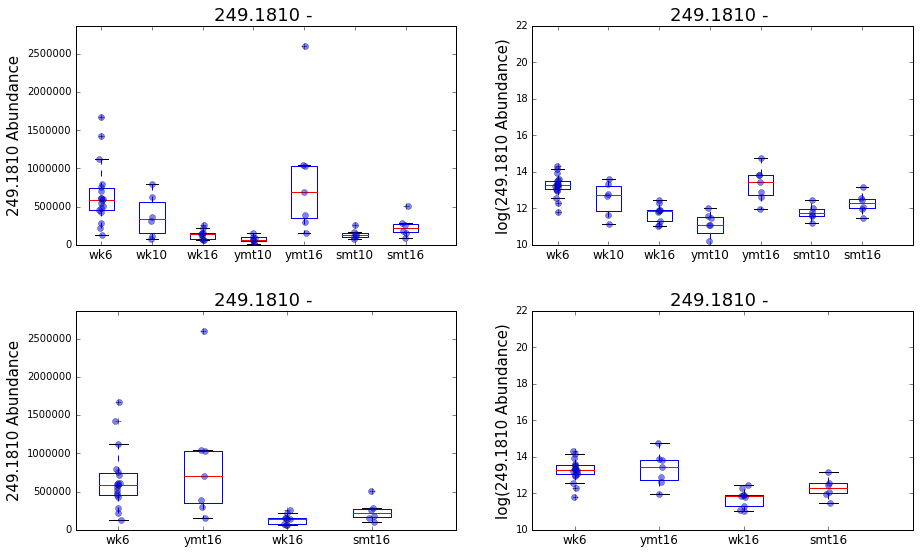

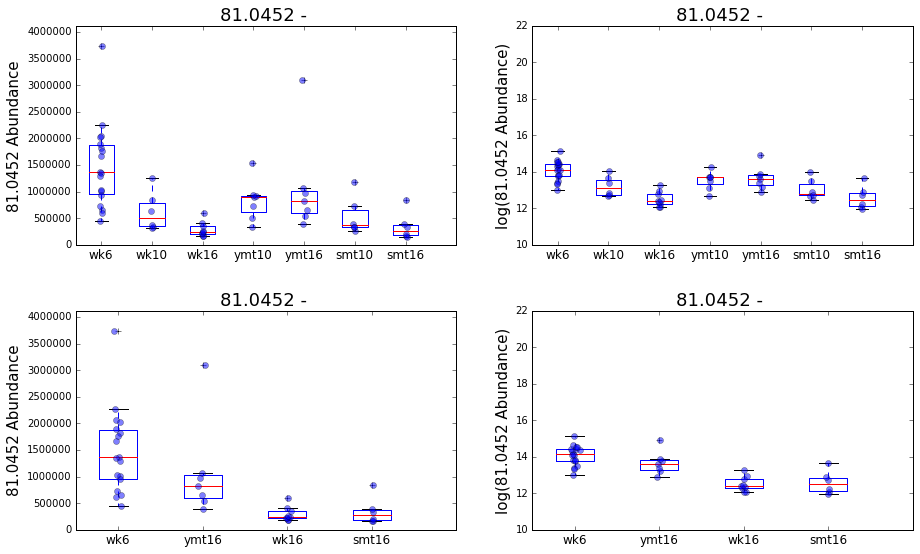

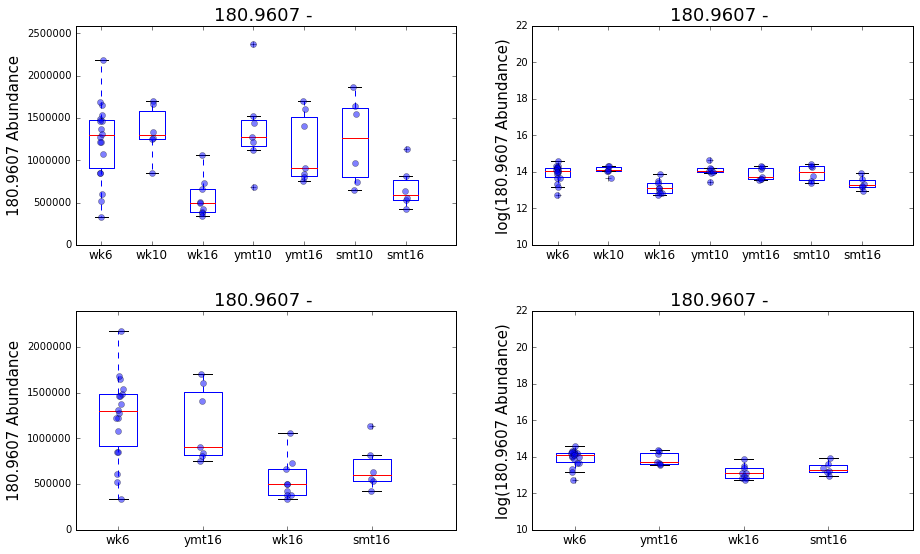

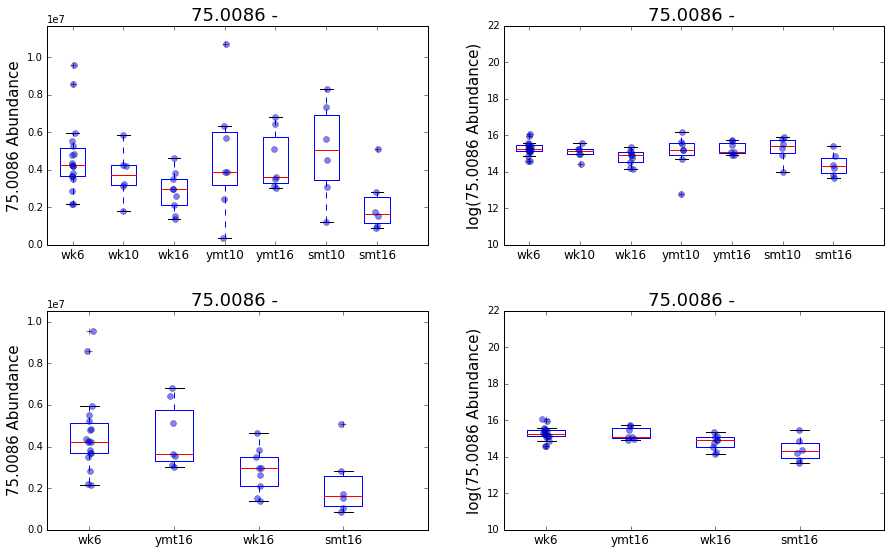

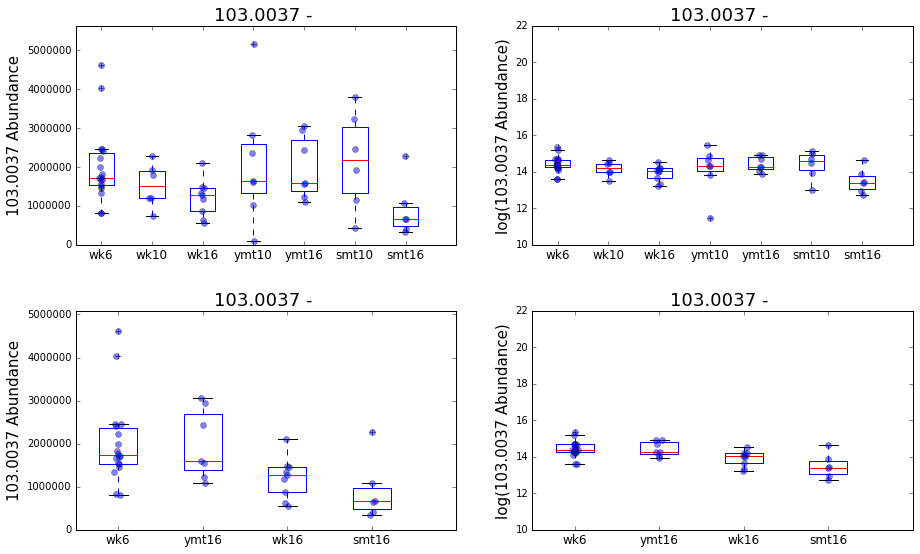

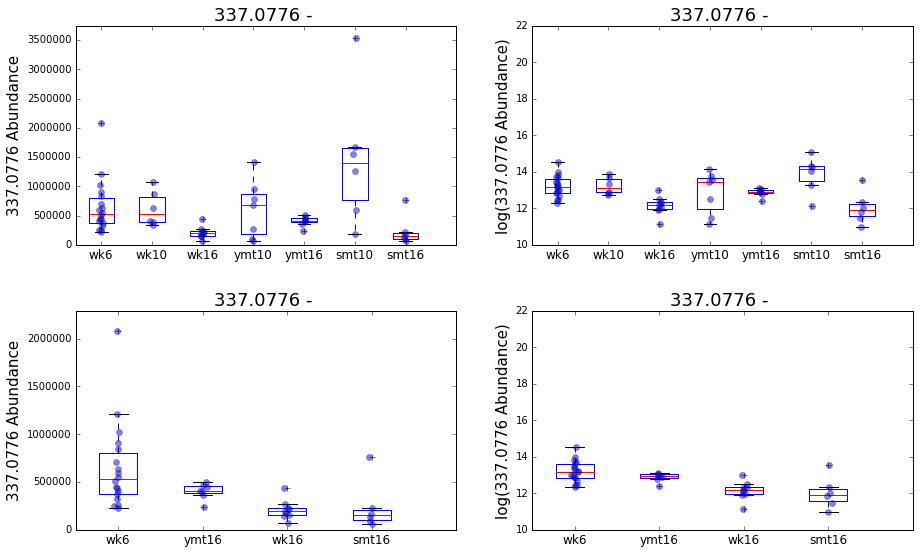

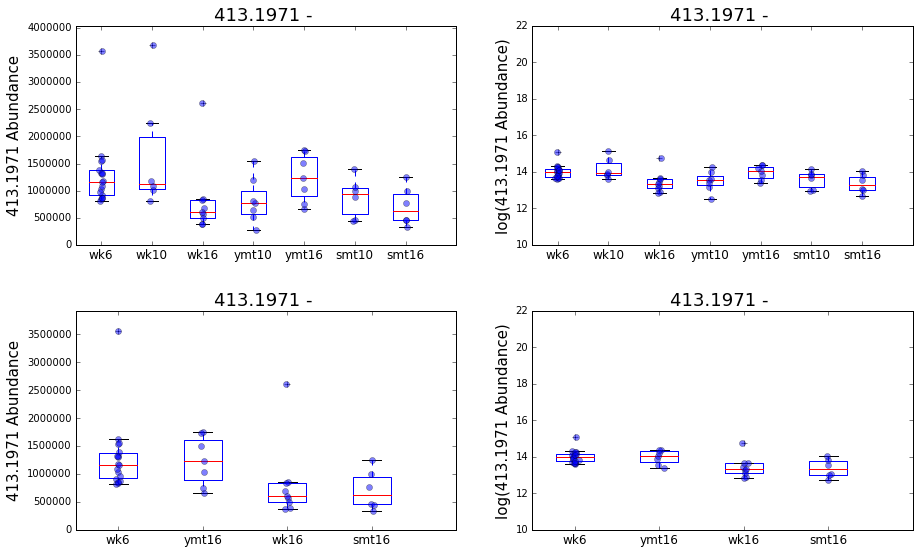

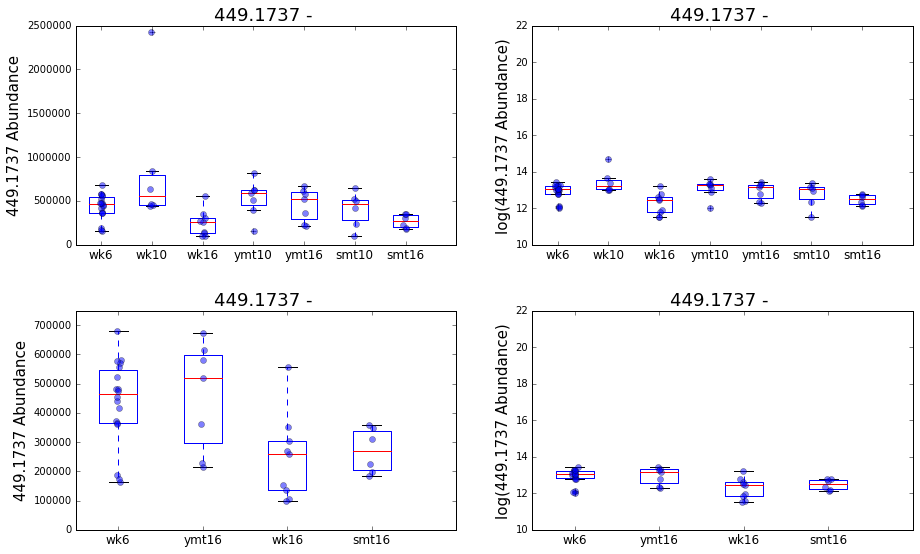

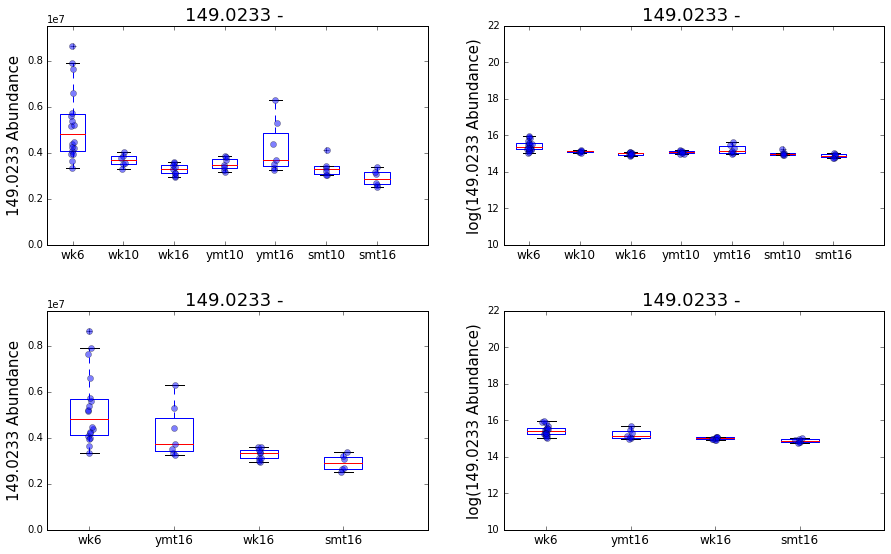

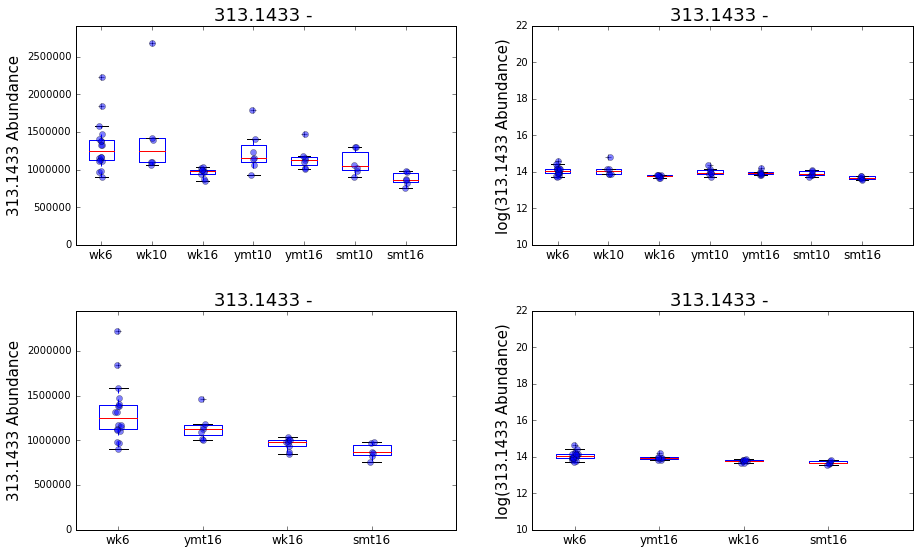

In [77]:
for i in z1:
    plotit(i)